# Mnist DataEngineer (Inference Stage/Operation Stage)

****DataEngineerTeam****: Responsible for deploying the machine learning model by using batch workflows or online model serving, and managing the inference workflow or service
- *Steps*
    1. Import Scanflow and check the local environment
    2. Develop scanflow application (workflows, agents)
    3. Build scanflow application
    **(step2-step3 can be repeated in order to get the final inference workflow)**
    4. Deploy scanflow environment
    5. Download production models
    6. Submit the metadata and artifacts to the central Scanflow-tracker
    7. ****[Inference]****
        1. Batch-inference (Argo)
        2. Online-inference (Seldon)
    **(step7 can be auto-managed by MAS)**
    8. Clean environment
- *Deliverables*
    1. Built scanflow application metadata
    2. DataEngineerTeam artifacts

## Steps
### Step1: Import Scanflow and check the local environment
1. import scanflow
    - For defining and building scanflow application, we need to import ScanflowClient
    - For deploying scanflow application, we need to import ScanflowDeployerClient
    - For saving artifacts, we need to import ScanflowTrackerClient
2. check local environment
    - For deploying scanflow application
        - If user starts the notebook at local and has the privilege to submit object on Kubernetes. We don't need to configure "SCANFLOW_SERVER_URI"
        - If user starts the notebook inside Kubernetes pod, or the local user does not have privilege to connect Kubernetes. We need to configure "SCANFLOW_SERVER_URI"
    - For saving deliverables, we need to configure url of Scanflow-tracker on "SCANFLOW_TRACKER_URI" and url of Scanflow-local-tracker on "SCANFLOW_TRACKER_LOCAL_URI"
    - If Scanflow-tracker is using S3 artifact storage, we need to configure S3 url "MLFLOW_S3_ENDPOINT_URL", username "AWS_ACCESS_KEY_ID" and password "AWS_SECRET_ACCESS_KEY"

In [1]:
import sys
import os
sys.path.insert(0,'../..')

import scanflow
from scanflow.client import ScanflowClient
from scanflow.client import ScanflowTrackerClient
from scanflow.client import ScanflowDeployerClient

In [2]:
from scanflow.tools import env
print(env.get_env("SCANFLOW_SERVER_URI"))
print(env.get_env("SCANFLOW_TRACKER_URI"))
#print(env.get_env("SCANFLOW_TRACKER_LOCAL_URI"))
print(env.get_env("MLFLOW_S3_ENDPOINT_URL"))
print(env.get_env("AWS_ACCESS_KEY_ID"))
print(env.get_env("AWS_SECRET_ACCESS_KEY"))

http://84.88.189.179:32767
http://84.88.189.179:32766
http://84.88.189.179:32645
scanflow
scanflow123


### Step2: Develop scanflow application

  1. develop component (requirement.txt, script.py)
  2. define scanflow workflows (Executor, Dependency, Workflow)
  3. define agents to supervise the workflows
  4. define scanflow application
  ```bash
     Application
        - List: Workflow(DAG)
                  - List: Executor
                  - List: Dependency
        - List: Agents(Web Services)
  ```
  
  
     For example:
     
  ```bash
  mnist
    - workflows
       - load_data
         - loaddata.py
       - predictor-batch
         - predictor.py
       - detector-batch
         - checker.py
       - pick-data
         - pick-data.py
    - agents
       - tracker
       - checker
       - improver
```


#### 2.1. Develop scanflow workflows

In [3]:
# App folder
scanflow_path = "/home/rocky/k8s_resources/scanflow"
app_dir = os.path.join(scanflow_path, "examples/mnist/dataengineer")
app_name = "mnist"
team_name = "dataengineer"

# scanflow client
client = ScanflowClient(
              #if you defined "SCANFLOW_SERVER_URI", you dont need to provide this
              #scanflow_server_uri="http://172.30.0.50:46666",
              verbose=True)

In [4]:
#predictor
executor1 = client.ScanflowExecutor(name='load-data', 
                      mainfile='loaddata.py',
                      parameters={'app_name': app_name,
                                  'team_name': 'data'})

executor2 = client.ScanflowExecutor(name='predictor-batch', 
                      mainfile='predictor.py',
                      parameters={'model_name': 'mnist_cnn',
                                  'input_data': '/workflow/load-data/mnist/data/mnist_sample/test_images.npy',
                                  'model_version': 1},
                      base_image='modeling-cnn1')


dependency1 = client.ScanflowDependency(dependee='load-data',
                                    depender='predictor-batch')

##workflow1 batch-inference
## -- load_data
##       -- predictor-batch
workflow1 = client.ScanflowWorkflow(name='batch-inference', 
                     nodes=[executor1, executor2],
                     edges=[dependency1],
                     type="batch",
                     output_dir = "/workflow")
              

In [5]:
#predictor online
# Note seldon using rclone after 1.8.0
#https://docs.seldon.io/projects/seldon-core/en/latest/servers/overview.html#handling-credentials
#https://docs.seldon.io/projects/seldon-core/en/latest/servers/kfserving-storage-initializer.html
# Current default storage initializer is seldonio/rclone-storage-initializer:1.12.0-dev
# so we have to claim the previous storageInitializer in seldon-config configmap or define in the graph metadata
# storageInitializer:
#   image: gcr.io/kfserving/storage-initializer:v0.4.0

service = client.ScanflowService(name='predictor-online',
                                 implementation_type = 'TENSORFLOW_SERVER',
                                 modelUri = 's3://scanflow/scanflow-mnist-dataengineer/1/d41424882d314d048c611b7e84960c8e/artifacts/mnist-tf/model',
                                 envSecretRefName = 'scanflow-secret',
                                 endpoint = {'type': 'GRPC'},
                                 parameters=[{'name': 'model_name', 'type':'STRING', 'value':'predictor-online'},
                                             {'name': 'model_input', 'type':'STRING', 'value':'input_1'},
                                             {'name': 'model_output', 'type':'STRING', 'value':'dense_1'}]
                                )

##workflow2 online-inference
##       -- predictor-online
workflow2 = client.ScanflowWorkflow(name='online-inference', 
                     nodes=[service],
                     type="online",
                     output_dir = "/workflow")

In [6]:
#checker workflow
executor3 = client.ScanflowExecutor(name='load-data', 
                      mainfile='loaddata.py',
                      parameters={'experiment_name': 'checker',
                                  'run_id': '',
                                  'path': 'data'})

executor4 = client.ScanflowExecutor(name='detector-batch', 
                      mainfile='checker.py',
                      parameters={'model_name': 'mnist_detector',
                                  'input_data': '/workflow/load-data/data/x_inference.npy'},
                      base_image='checker')

executor5 = client.ScanflowExecutor(name='pick-data', 
                      mainfile='pick-data.py',
                      parameters={'e_inference': '/workflow/detector-batch/E_inference.csv',
                                  'x_inference_artifact': '/workflow/load-data/data/x_inference.npy',
                                  'y_inference_artifact': '/workflow/load-data/data/y_inference.npy'}, 
                      base_image='checker')

dependency2 = client.ScanflowDependency(dependee='load-data',
                                    depender='detector-batch')

dependency3 = client.ScanflowDependency(dependee='detector-batch',
                                    depender='pick-data')

##workflow3
## -- load-predicted-data
##       -- detector-batch
##          -- pick-data
workflow3 = client.ScanflowWorkflow(name='detector-inference', 
                     nodes=[executor3, executor4, executor5],
                     edges=[dependency2, dependency3],
                     type="batch",
                     output_dir = "/workflow")

#### 2.2. Develop scanflow agents

In [7]:
#tracker(monitor)
trigger = client.ScanflowAgentSensor_IntervalTrigger(hours=1)
sensor = client.ScanflowAgentSensor(name='count_number_of_predictions',
                                    isCustom=True,
                                    func_name='count_number_of_predictions',
                                    trigger=trigger)
tracker = client.ScanflowAgent(name='tracker',
                              template='monitor',
                              sensors=[sensor])

In [8]:
#checker(analyzer)
# The frequency to retain the model is always in days. for testing we set 1 hour
# trigger = client.ScanflowAgentSensor_IntervalTrigger(day=1)
trigger = client.ScanflowAgentSensor_IntervalTrigger(hours=1)
sensor = client.ScanflowAgentSensor(name='count_number_of_newdata',
                                    isCustom=True,
                                    func_name='count_number_of_newdata',
                                    trigger=trigger)
checker = client.ScanflowAgent(name='checker',
                              template='analyzer',
                              sensors=[sensor])

In [9]:
#planner
# The frequency to change the model is always in days. for testing we set 1 hour
# trigger = client.ScanflowAgentSensor_IntervalTrigger(day=1)
trigger = client.ScanflowAgentSensor_IntervalTrigger(hours=1)
sensor = client.ScanflowAgentSensor(name='check_model_accuracy',
                                    isCustom=True,
                                    func_name='check_model_accuracy',
                                    trigger=trigger)
planner = client.ScanflowAgent(name='planner',
                              template='planner',
                              sensors=[sensor])

In [10]:
#executor
executor = client.ScanflowAgent(name='executor',
                              template='executor')

#### 2.3. Define scanflow application

In [11]:
app = client.ScanflowApplication(app_name = app_name,
                                 app_dir = app_dir,
                                 team_name = team_name,
                                 workflows=[workflow1, workflow2, workflow3],
                                 agents=[tracker, checker, planner, executor]
                                )

In [12]:
dic = app.to_dict()

31-Jan-24 09:41:22 -  INFO - workflow batch-inference: {'name': 'batch-inference', 'nodes': [{'name': 'load-data', 'node_type': 'executor', 'mainfile': 'loaddata.py', 'parameters': {'app_name': 'mnist', 'team_name': 'data'}, 'requirements': None, 'dockerfile': None, 'base_image': None, 'env': None, 'image': None, 'timeout': None, 'resources': None, 'affinity': None}, {'name': 'predictor-batch', 'node_type': 'executor', 'mainfile': 'predictor.py', 'parameters': {'model_name': 'mnist_cnn', 'input_data': '/workflow/load-data/mnist/data/mnist_sample/test_images.npy', 'model_version': 1}, 'requirements': None, 'dockerfile': None, 'base_image': 'modeling-cnn1', 'env': None, 'image': None, 'timeout': None, 'resources': None, 'affinity': None}], 'edges': [{'depender': 'predictor-batch', 'dependee': 'load-data', 'edge_type': 'dependency', 'priority': 0}], 'type': 'batch', 'resources': None, 'affinity': None, 'kedaSpec': None, 'hpaSpec': None, 'output_dir': '/workflow'}
31-Jan-24 09:41:22 -  INF

  
### Step3: Build scanflow application (local)
   
  1. build images for Executor -> save to image registry



In [22]:
build_app = client.build_ScanflowApplication(app = app, trackerPort=31001)

In [23]:
build_app.to_dict()

{'app_name': 'mnist',
 'app_dir': '/home/rocky/k8s_resources/scanflow/examples/mnist/dataengineer',
 'team_name': 'dataengineer',
 'workflows': [{'name': 'batch-inference',
   'nodes': [{'name': 'load-data',
     'node_type': 'executor',
     'mainfile': 'loaddata.py',
     'parameters': {'app_name': 'mnist', 'team_name': 'data'},
     'requirements': None,
     'dockerfile': None,
     'base_image': None,
     'env': None,
     'image': 'registry.gitlab.bsc.es/datacentric-computing/cloudskin-project/cloudskin-registry/load-data:latest',
     'timeout': None,
     'resources': None,
     'affinity': None},
    {'name': 'predictor-batch',
     'node_type': 'executor',
     'mainfile': 'predictor.py',
     'parameters': {'model_name': 'mnist_cnn',
      'input_data': '/workflow/load-data/mnist/data/mnist_sample/test_images.npy',
      'model_version': 1},
     'requirements': None,
     'dockerfile': None,
     'base_image': 'modeling-cnn1',
     'env': None,
     'image': 'registry.gitl

### Step2-Step3: Debugging Tips

   1. If dataengineer team want to change the parameters or structures of the workflow or agent, datascience team should change the definition by repeating step2
   2. If dataengineer team want to change the executed script inside the executor or agent functions. (It will be better team if could use local scanflow to debug their executor before deployment.)
      - delete the original executor images from image registry 
      - repeat step2-step3 to rebuild new images 
      - [agent change] recreate environment to start new agent
      - [workflow change] resubmit metadata, for online inference dataengineer should update the workflow

### Step4: Deploy scanflow environment (local/incluster)
  
  1. Create k8s environment
        - create namespace
        - create RBAC, secret, configmap, PV, PVC
        
  2. Deploy scanflow-local-tracker (deployment, service)
 
  3. Deploy scanflow-agents
       

In [15]:
deployerClient = ScanflowDeployerClient(user_type="local",
                                        deployer="seldon",
                                        k8s_config_file="/home/rocky/.kube/config",
                                       verbose=False)

In [16]:
deployerClient1 = ScanflowDeployerClient(user_type="local",
                                        deployer="argo",
                                        k8s_config_file="/home/rocky/.kube/config",
                                       verbose=False)

In [27]:
await deployerClient1.create_environment(app=build_app)

### Step5: download prepared production mnist model
   - download mnist-checker model (e.g., mnist_detector)
   - download mnist model (e.g., mnist_cnn)            


In [17]:
trackerClient = ScanflowTrackerClient(scanflow_tracker_local_uri="http://84.88.189.179:31001",
                        verbose=False)

In [19]:
trackerClient.download_app_model(model_name="mnist_cnn", model_version="1")

23-Jan-24 13:08:30 -  INFO - Found credentials in environment variables.
/home/rocky/local_resources/miniconda3/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024/01/23 13:08:32 INFO mlflow.tracking.fluent: Experiment with name 'mnist' does not exist. Creating a new experiment.
2024/01/23 13:08:41 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: mnist_cnn, version 1


In [20]:
trackerClient.download_app_model(model_name="mnist_detector", model_version="1")

2024/01/23 13:08:45 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: mnist_detector, version 1


In [21]:
# trackerClient.download_app_model(model_name="mnist-tf")

### Step6: Submit the metadata and artifacts to the central Scanflow-tracker

  #### 6.1. Submit scanflowapp metadata
  ```bash
   mnist
    - dataengineer
     - workflows
        - batch-inference.json
        - detector-inference.json
     - mnist.json
  ```

In [16]:
trackerClient = ScanflowTrackerClient(scanflow_tracker_local_uri="http://84.88.189.179:31001",
                        verbose=False)

In [22]:
trackerClient.save_app_meta(build_app)

#### 6.2. Submit artifacts

  ```bash
mnist
    - workflows
       - load_data
         - loaddata.py
       - predictor-batch
         - predictor.py
       - detector-batch
         - checker.py
       - pick-data
         - pick-data.py
       - predictor-online
    - agents
       - tracker
       - checker
       - planner
       - executor
```


In [23]:
trackerClient.save_app_artifacts(app_name=app_name, 
                                team_name=team_name, 
                                app_dir=app_dir)

### Step7: ****[Inference]****

#### 7.1. Batch Inference

Batch worklflow(workflow[0]:batch-inference) is defined by dataengineer, client could use it by changing the parameters.

Below simulate the client makes predictions by using default parameters

In [19]:
await deployerClient1.run_workflow(app_name='mnist', 
                                  team_name='dataengineer',
                                  workflow = build_app.workflows[0])

apiVersion: argoproj.io/v1alpha1

kind: Workflow

metadata:
  name: batch-inference

spec:

  affinity: {}

  entrypoint: batch-inference

  templates:

    - dag:
        tasks:
          - name: load-data
            template: load-data
          - dependencies:
              - load-data
            name: predictor-batch
            template: predictor-batch
      name: batch-inference

    - container:
        command:
          - python
          - /app/load-data/loaddata.py
          - --app_name
          - mnist
          - --team_name
          - data
        env:
          - name: AWS_ACCESS_KEY_ID
            value: scanflow
          - name: AWS_SECRET_ACCESS_KEY
            value: scanflow123
          - name: MLFLOW_S3_ENDPOINT_URL
            value: http://minio.scanflow-server.svc.cluster.local
          - name: AWS_ENDPOINT_URL
            value: http://minio.scanflow-server.svc.cluster.local
          - name: SCANFLOW_TRACKER_URI
            value: http://scanflow-trac

True

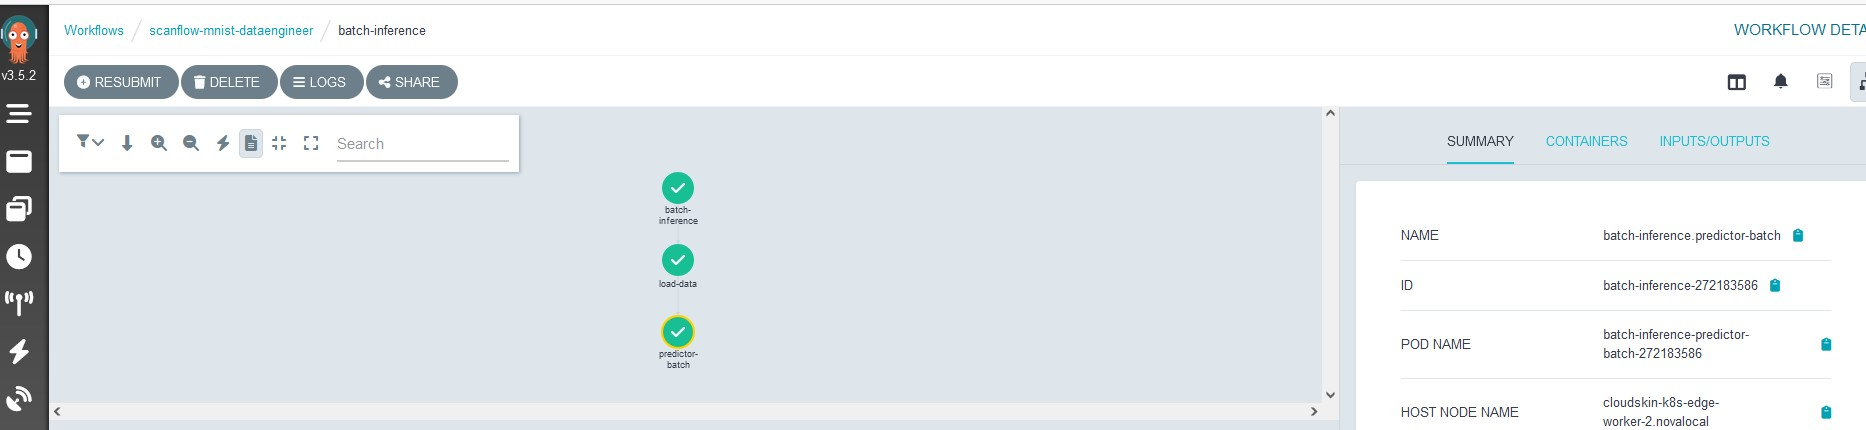

In [24]:
from IPython.display import Image
Image("/home/rocky/k8s_resources/scanflow/images/cloudskin/dataengineer-batch-inference.jpg", width=1200, height=400)

#### 7.2. Online Inference 
Online workflow(workflow[1]:online-inference) is defined by dataengineer, first dataengineer should deploy the workflow as services by using seldon, then client could send request to get the predictions.

In [28]:
await deployerClient.deploy_workflow(app_name='mnist', 
                                  team_name='dataengineer',
                                  workflow = build_app.workflows[1], replicas=1)

{'apiVersion': 'machinelearning.seldon.io/v1',
 'kind': 'SeldonDeployment',
 'metadata': {'creationTimestamp': '2021-12-07T21:31:03Z',
  'generation': 1,
  'managedFields': [{'apiVersion': 'machinelearning.seldon.io/v1',
    'fieldsType': 'FieldsV1',
    'fieldsV1': {'f:spec': {'.': {}, 'f:name': {}, 'f:predictors': {}}},
    'manager': 'OpenAPI-Generator',
    'operation': 'Update',
    'time': '2021-12-07T21:31:03Z'}],
  'name': 'online-inference',
  'namespace': 'scanflow-mnist-dataengineer',
  'resourceVersion': '13174017',
  'selfLink': '/apis/machinelearning.seldon.io/v1/namespaces/scanflow-mnist-dataengineer/seldondeployments/online-inference',
  'uid': '06c7a2df-ec1e-46aa-b7e2-8ab8bc84e3f7'},
 'spec': {'name': 'online-inference',
  'predictors': [{'graph': {'endpoint': {'type': 'GRPC'},
     'envSecretRefName': 'scanflow-secret',
     'implementation': 'TENSORFLOW_SERVER',
     'modelUri': 's3://scanflow/scanflow-mnist-dataengineer/1/d41424882d314d048c611b7e84960c8e/artifacts/m

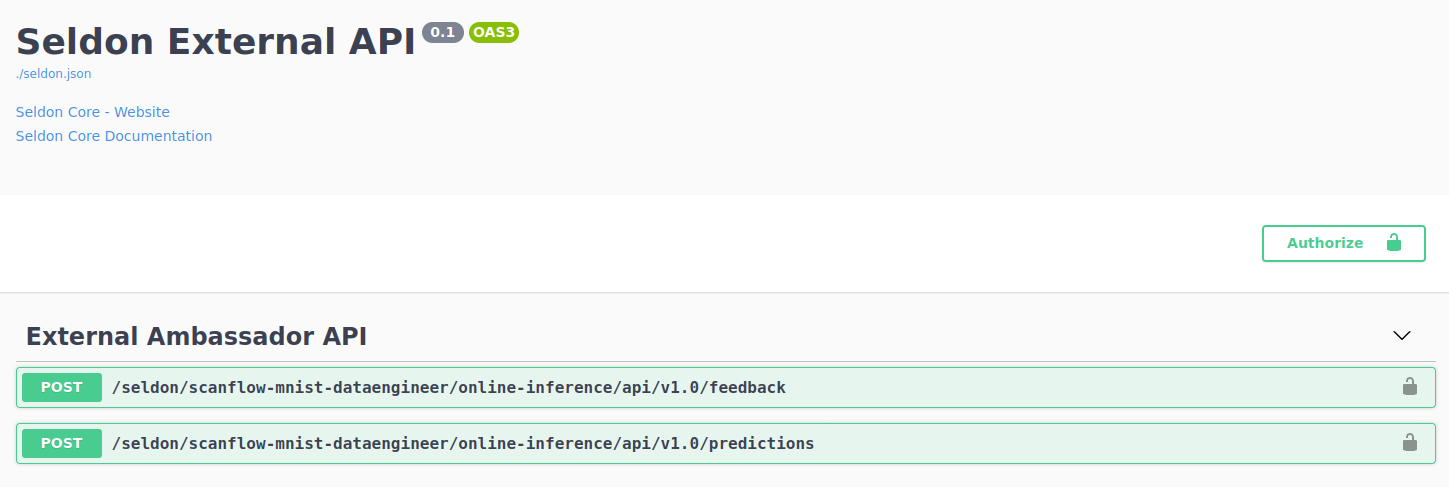

In [50]:
from IPython.display import Image
Image("/gpfs/bsc_home/xpliu/pv/jupyterhubpeini/scanflow/images/seldon-api.PNG", width=1200, height=400)

 
[online-inference] http://172.30.0.50:40000/seldon/scanflow-mnist-dataengineer/online-inference/api/v1.0/doc/#/
  

In [18]:
await deployerClient.delete_workflow(app_name='mnist', 
                                  team_name='dataengineer',
                                  workflow = build_app.workflows[0])

False


  
### Step8: Clean scanflow environment
  
  1. delete environment
  

In [21]:
await deployerClient.clean_environment(app=build_app)

## Deliverables

After steps, you could check the deliverable from the central Scanflow-tracker http://172.30.0.50:46667.


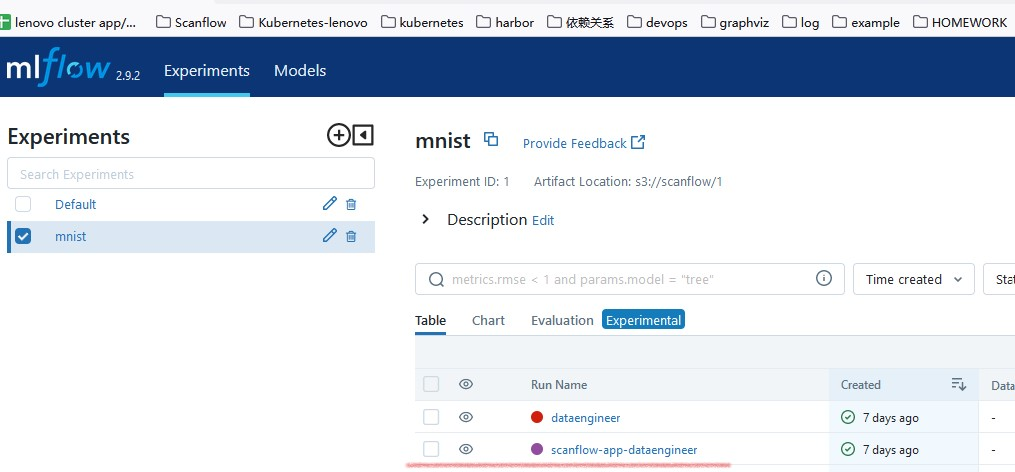

In [26]:
from IPython.display import Image
Image("/home/rocky/k8s_resources/scanflow/images/cloudskin/dataengineer-d.jpg", width=1200, height=400)

### Deliverable1: DataEngineerTeam built scanflow application metadata

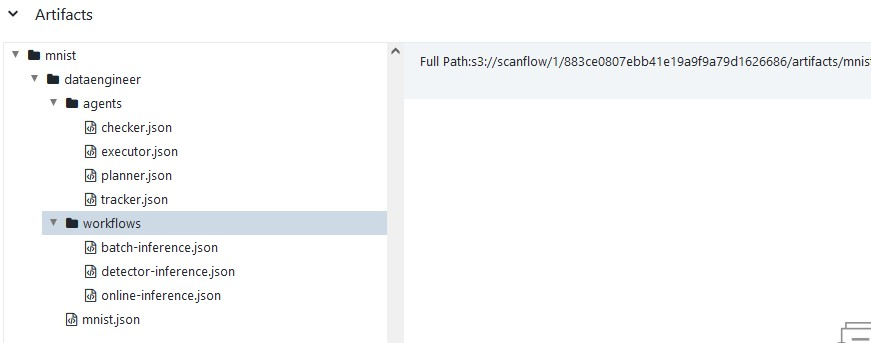

In [27]:
from IPython.display import Image
Image("/home/rocky/k8s_resources/scanflow/images/cloudskin/dataengineer-d1.jpg", width=1000, height=400)

### Deliverable2: DataEngineerTeam artifacts

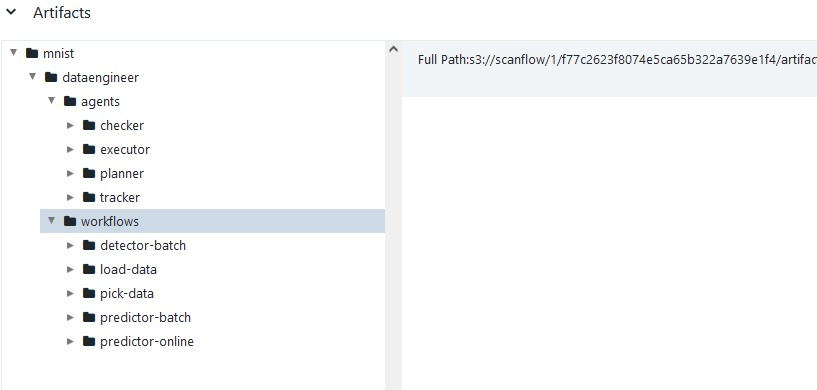

In [28]:
from IPython.display import Image
Image("/home/rocky/k8s_resources/scanflow/images/cloudskin/dataengineer-d2.jpg", width=1000, height=400)